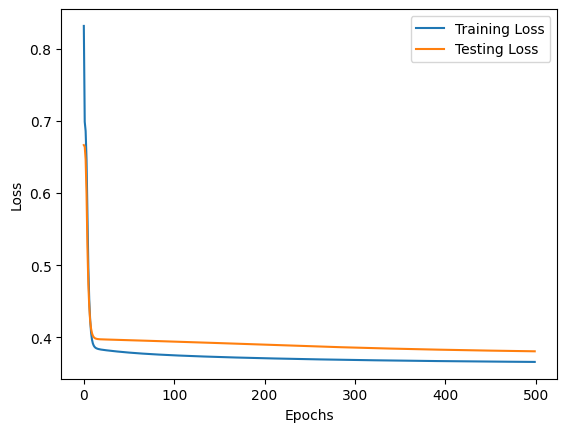

Test Accuracy: 66.67%


In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from random import seed, random
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed(1)

# Load IRIS dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# One-hot encode target
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=1)

# Initialize a network with regularization term lambda
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = [
        [{'weights': [random() for _ in range(n_inputs + 1)]} for _ in range(n_hidden)],
        [{'weights': [random() for _ in range(n_hidden + 1)]} for _ in range(n_outputs)]
    ]
    return network

# Activation functions
def activate(weights, inputs):
    return sum(w * i for w, i in zip(weights[:-1], inputs)) + weights[-1]

def transfer(activation):
    return 1.0 / (1.0 + np.exp(-activation))

def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

def transfer_derivative(output):
    return output * (1.0 - output)

# Backpropagation with error calculation
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = []
        if i != len(network) - 1:
            for j in range(len(layer)):
                error = sum(neuron['weights'][j] * neuron['delta'] for neuron in network[i + 1])
                errors.append(error)
        else:
            errors = [neuron['output'] - expected[j] for j, neuron in enumerate(layer)]
        for j, neuron in enumerate(layer):
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

# Update weights with regularization
def update_weights(network, row, l_rate, reg_lambda):
    for i in range(len(network)):
        inputs = row[:-1] if i == 0 else [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] -= l_rate * (neuron['delta'] * inputs[j] + reg_lambda * neuron['weights'][j])
            neuron['weights'][-1] -= l_rate * neuron['delta']  # Bias update without regularization

# Train the network
def train_network(network, train, l_rate, n_epoch, n_outputs, reg_lambda):
    train_losses = []
    test_losses = []
    for epoch in range(n_epoch):
        epoch_loss = 0
        for row, expected in zip(train[0], train[1]):
            outputs = forward_propagate(network, row)
            expected_output = [0 for _ in range(n_outputs)]
            expected_output[np.argmax(expected)] = 1
            epoch_loss += sum((outputs[i] - expected_output[i]) ** 2 for i in range(n_outputs))
            backward_propagate_error(network, expected_output)
            update_weights(network, row, l_rate, reg_lambda)
        train_losses.append(epoch_loss / len(train[0]))

        # Track test loss for plotting
        test_loss = sum(
            sum((forward_propagate(network, row)[i] - test_row[i]) ** 2 for i in range(n_outputs))
            for row, test_row in zip(X_test, y_test)
        )
        test_losses.append(test_loss / len(X_test))
    return train_losses, test_losses

# Make a prediction
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))

# Set network parameters and initialize
n_inputs = X.shape[1]
n_hidden = 5
n_outputs = y_encoded.shape[1]
l_rate = 0.3
n_epoch = 500
reg_lambda = 0.01

network = initialize_network(n_inputs, n_hidden, n_outputs)

# Train and get loss curves
train_losses, test_losses = train_network(network, (X_train, y_train), l_rate, n_epoch, n_outputs, reg_lambda)

# Plot the training and testing curves
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate accuracy on test set
predictions = [predict(network, row) for row in X_test]
actual = [np.argmax(row) for row in y_test]
accuracy = sum(int(pred == act) for pred, act in zip(predictions, actual)) / len(actual) * 100
print(f"Test Accuracy: {accuracy:.2f}%")
